# TODO:
1. Experiment with other types of loss
2. Make problem out of this notebook

# Problem description
The following problem is proposed: 

6x6 images are generated as one of two distinct classes.

0. Class 0 represents noise as i.i.d. ~ Uniform(low, high), where low and high are parameters that determine the noise level.
1. Class 1 takes class 0 and inserts a 3x3 square by setting each element in a 3x3 grid to a predefined value, starting from a random spot in the image.

The problem then becomes to create a binary classification network that can separate these two. 

# Given
1. The network architecture  

| **Layer**   | **Input dim** | **Output dim** | **Other**                                                  |
|-------------|---------------|----------------|------------------------------------------------------------|
| Input       | 6x6           | 6x6            | Class 0 or 1                                               |
| 2D convolve | 6x6           | 4x4            | Kernel: 3x3 with stride 1 and no padding. Activation: ReLU |
| Max pool    | 4x4           | 2x2            | Kernel: 2x2 with stride 2 and no padding.                  |
| Flatten     | 2x2           | 4x1            |                                                            |
| FCNN        | 4x1           | 1              | Activation: Sigmoid                                        |

which has a total of 15 parameters, decomposed into 2 biases from the CNN and FCNN, 9 kernel weights in the CNN and 4 weights in the FCNN.

2. An input matrix *X* and a label *y*, where *y* = 0 when *X* is all uniform and *y* = 1 when *X* contains a square.

# Find
1. The intermediate values in both the CNN and FCNN part
2. Post-activation for a forward pass
3. Loss for a forward pass
3. Gradient of the loss function w.r.t. the network parameters


# Imports and helper functions

In [3566]:
import numpy as np

import matplotlib.pyplot as plt

from dataclasses import dataclass

from __future__ import annotations
from itertools import product


class Matrix2D():

    def __init__(self, array: np.ndarray):
        assert len(array.shape) == 2, "Input array must be 2D!"

        self.data: np.ndarray = array
        self.nrow: int = array.shape[0]
        self.ncol: int = array.shape[1] 

    def __getitem__(self, key):
        return self.data[key]

    def __setitem__(self, key, val):
        self.data[key] = val

    @staticmethod
    def gaussian(center, ndim, sigma = 1):

        xx, yy = np.meshgrid(
            np.linspace(0, ndim-1, ndim) - center[0],
            np.linspace(0, ndim-1, ndim) - center[1]
        )
        return Matrix2D(np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma)))
        
    @staticmethod
    def uniform_noise(ndim_matrix: int, intensity: float = 1.0) -> Matrix2D:
        return Matrix2D(np.random.uniform(-intensity, intensity, (ndim_matrix, ndim_matrix)))

    @staticmethod
    def square(ndim_matrix: int, ndim_square: int) -> Matrix2D:
        matrix = Matrix2D.uniform_noise(ndim_matrix)

        # Select top left corner to draw square from
        top_left_row = np.random.randint(low=0, high = ndim_matrix - ndim_square)
        top_left_col = np.random.randint(low=0, high = ndim_matrix - ndim_square)

        matrix[top_left_row:top_left_row + ndim_square, top_left_col:top_left_col + ndim_square] = 5.0

        return matrix

    def draw(self, title: str = "") -> None:
        """Display a visualization of the matrix values

        See: https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap
        """
        fig, ax = plt.subplots()

        ax.matshow(self.data, cmap=plt.cm.Blues)

        if self.nrow == 1:
            for col in range(self.ncol):
                ax.text(col, 0, f"{self.data[0, col]:.2f}", va='center', ha='center')
        elif self.ncol == 1:
            for row in range(self.nrow):
                ax.text(0, row, f"{self.data[row, 0]:.2f}", va='center', ha='center')
        else:
            for col, row in np.ndindex(self.data.shape):
                ax.text(col, row, f"{self.data[row, col]:.2f}", va='center', ha='center')


        ax.set_title(title)

    def convolve2D(self, kernel: Matrix2D, bias: float = 0, stride: int = 1) -> Matrix2D:
        """Convolve the 2D matrix with a 2D kernel plus bias

        See http://www.songho.ca/dsp/convolution/convolution2d_example.html for the math
        """
        assert stride != 0, "Stride cannot be zero!"

        output_width: int = (self.nrow - kernel.nrow) // stride + 1
        output_height: int = (self.ncol - kernel.ncol) // stride + 1

        output_image = np.zeros((output_height, output_width))

        for col, row in product(range(0, output_width, stride), range(0, output_height, stride)):
            output_image[row, col] = \
                self.data[row:row+kernel.ncol, col:col+kernel.nrow].flatten() \
                @ kernel.data.flatten() \
                + bias 

        return Matrix2D(output_image)

    def maxpool(self, ndim: int = 1, stride: int = 1):
        """Dimension reduction using the max of a neigborhood defined by ndim

        See https://computersciencewiki.org/index.php/Max-pooling_/_Pooling for the math
        and https://datascience.stackexchange.com/questions/11699/backprop-through-max-pooling-layers
        for the intuition on why the indices of the maximum values for each pool is needed
        """
        assert stride != 0, "Stride cannot be zero!"

        output_width: int = (self.nrow - ndim) // stride + 1
        output_height: int = (self.ncol - ndim) // stride + 1

        output_image = np.zeros((output_height, output_width))
        indices = []

        for row, col in product(range(output_height), range(output_width)):
            rows = slice(row * ndim, (row+1) * ndim)
            cols = slice(col * ndim, (col+1) * ndim)
            pool = self.data[rows, cols]
            
            output_image[row, col] = np.max(pool)

            index = np.add(np.unravel_index(np.argmax(pool), pool.shape), (row * col, col * row))
            indices.append(index)
        
        return Matrix2D(output_image), indices

    def flatten(self):
        return Matrix2D(self.data.flatten().reshape(self.nrow*self.ncol, 1))


@dataclass
class Network():
    learning_rate: float = 0.1

    kernel: Matrix2D = None
    conv_bias: float = 0.0

    weights: np.ndarray = np.empty(0)
    fcnn_bias: float = 0.0

    backward: bool = False
    maxpool_indices: np.ndarray = np.empty(0)

    # parameters - hardcoded for this solution and will be None until the first forward pass
    z1: Matrix2D = None
    a1: Matrix2D = None
    a2: Matrix2D = None
    a3: Matrix2D = None
    z4: float = None
    a4: float = None

    def fcnn_forward(self, x):
        return self.weights @ x + self.fcnn_bias

    def relu(self, value):
        """ReLU activation"""
        act = value > 0

        if self.backward:
            return act * 1

        return act * abs(value)

    def leaky_relu(self, value):
        """Leaky ReLU as a solution to dying ReLUs"""
        a = 0.01
        
        if self.backward:
            return np.where(value > 0, 1, a) 

        return np.where(value > 0, value, value * a)

    def sigmoid(self, value):
        """Sigmoid activation"""
        act = np.exp(value) / (1 + np.exp(value))

        if self.backward:
            return act * (1 - act)

        return act

    def binary_cross_entropy(self, y: float, p: float) -> float:
        """Binary cross entropy loss calculation

        See: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
        """
        if self.backward:
            return (1 - y) / (1 - p) - (y / p)

        return  - (y * np.log10(p) + (1 - y) * np.log10(1 - p))

    def forward_pass(self, X, y):
        """A full single forward pass, given an input image X and the class y it belongs to"""
        self.backward = False
        
        self.z1 = X.convolve2D(self.kernel, bias=self.conv_bias, stride=1) # TODO: Move to parameter list
        self.a1 = Matrix2D(self.relu(self.z1.data))

        self.a2, self.maxpool_indices = self.a1.maxpool(ndim=2, stride=2) # TODO: Move to parameter list
        self.a3 = self.a2.flatten()

        self.z4 = self.fcnn_forward(self.a3.data)[0, 0]
        self.a4 = self.sigmoid(self.z4)

        return None if y is None else self.binary_cross_entropy(y, self.a4) 
        
    def backward_pass(self, X, y):
        """A full single forward pass, given an input image X and the class y it belongs to"""
        self.backward = True

        delta = self.binary_cross_entropy(y, self.a4) * self.sigmoid(self.z4)
        self.fcnn_bias -= self.learning_rate * delta # Update bias for the FCNN

        delta = delta * self.a3.data 
        self.weights -= self.learning_rate * delta.T # Update weights for the FCNN

        delta_temp = np.zeros_like(self.a1.data)
        for max_indices, gradient in zip(self.maxpool_indices, delta):
            delta_temp[max_indices] = gradient

        delta = self.relu(self.z1.data) * delta_temp

        grad_conv_bias = delta.sum()
        grad_kernel = X.convolve2D(Matrix2D(delta))

        # Update weights and bias for convolution
        self.kernel.data -= self.learning_rate * grad_kernel.data
        self.conv_bias -= self.learning_rate * grad_conv_bias

    def predict(self, X):
        """A full single forward pass, without needing the class y"""
        self.forward_pass(X, None)
        print(f"prob. for class 0 (no square): {1 - self.a4}")
        print(f"prob. for class 1 (square): {self.a4}")

# Example of data and usage of the Network class

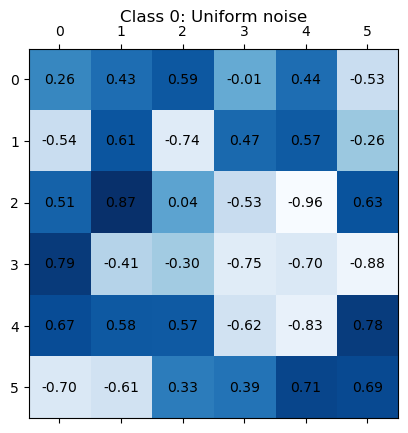

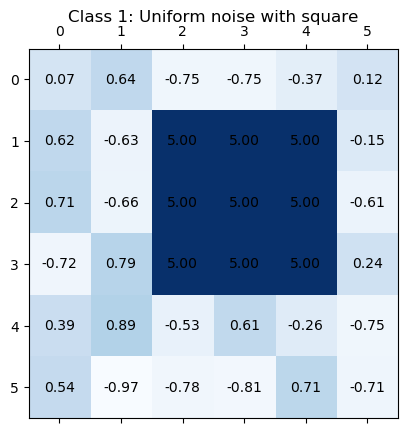

In [3567]:
np.random.seed()

# Create Matrix2D for class 0 and 1
ndim = 6

X0 = Matrix2D.uniform_noise(ndim)
X1 = Matrix2D.square(ndim, 3)
X0.draw("Class 0: Uniform noise")
X1.draw("Class 1: Uniform noise with square")


# Forward pass - annotated
The cells below provide an annotated view of the contents of the forward() function of the Network class

We start off by initializing the network parameters. This includes:
1. The 3x3 kernel, initialized with i.i.d. ~ Uniform(-1, 1) elements
2. The convolution bias, initialized as ~ Uniform(0, 1)
3. The FCNN weights, initialized with i.i.d. ~ Uniform(-1, 1) elements
4. The FCNN bias, initialized as ~ Uniform(0, 1)
These are all learnable parameters in the network.

A class 1 example image is also generated for use in the forward and backward pass example.

In [3568]:
# Initialize the network
kernel = Matrix2D(np.random.uniform(low=-1, high=1, size=(3, 3)))
conv_bias = np.random.uniform()

fcnn_weights = np.random.uniform(low=-1, high=1, size=(1, 4))
fcnn_bias = np.random.uniform()

nn = Network(learning_rate=0.01, kernel=kernel, conv_bias=conv_bias, weights=fcnn_weights, fcnn_bias=fcnn_bias)

# Use class 1 as an example
y = 1
X = Matrix2D.square(ndim, 3)

#### Convolution
Since the kernel is initialized to random values, trying to assign any meaning to the output of the convolution layer at this stage does not make sense. It is instead better to understand how the values in the convolved output image are generated. See [this gif to get a visualization of the convolution operation](https://theano-pymc.readthedocs.io/en/latest/_images/numerical_no_padding_no_strides.gif).

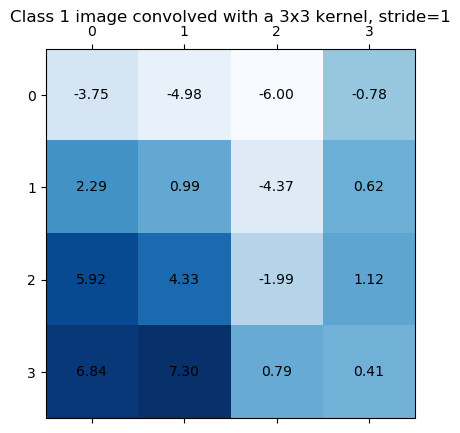

In [3569]:
z1 = X.convolve2D(kernel, bias=conv_bias, stride=1)
z1.draw("Class 1 image convolved with a 3x3 kernel, stride=1")

#### ReLU 
The ReLU function applies max(0, value) element-wise which adds a nonlinearity to the network. [[1]](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf) lists some of the benefits of having a ReLU activation, mainly sparsity and fast training times. While neither of these are problematic for such a small-scale problem as here, it yields an extra step to discuss and perform calculations on :)

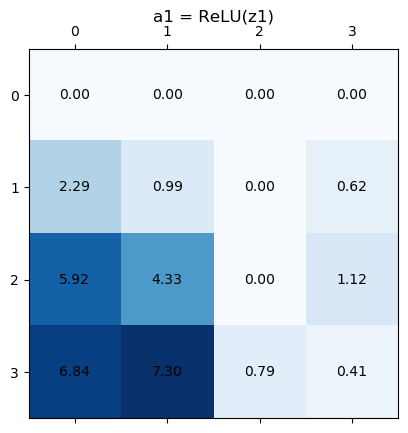

In [3570]:
a1 = Matrix2D(nn.relu(z1.data))
a1.draw("a1 = ReLU(z1)")

#### Maxpool
Our binary classifier needs a fully-connected neural network between the augmented input matrix and the output. However, due to the sparsity introduced by the ReLU operation, and for scalability concerns, it is reasonable to decimate the augmented image to a lower dimension, and this is what maxpool does. Mathematically, it is similar to convolution in that a sliding window (kernel) is applied to the image. However, instead of weighing the image elements with the kernel data, the maximum image value inside a given window is extracted to the output of the maxpool operation. Again, [I refer to an animation that visualizes this](https://thumbs.gfycat.com/FirstMediumDalmatian-size_restricted.gif).

Instead of requiring 16 weights in our FCNN, we now only need 4 - which is good - from both the perspective of parsimonity and computational demand (again, the latter is not *really* a concern for us.)

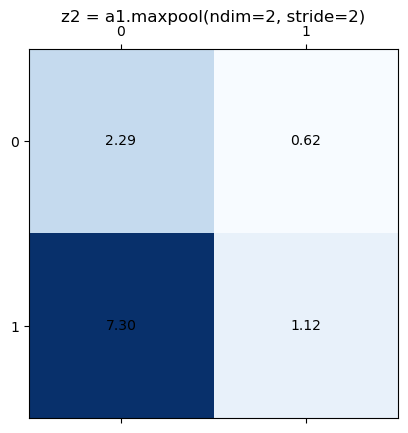

In [3571]:
a2, maxpool_indices = a1.maxpool(ndim=2, stride=2)
a2.draw("z2 = a1.maxpool(ndim=2, stride=2)")

#### FCNN

The FCNN consists of four weights, one for each cell of the maxpool output. In addition, a bias term is introduced to avoid being restricted to only being able to model functions where f(0) = 0

The pre-activation value is calculated by the dot-product between the weights and the input vector, plus bias.

Since the purpose of the network is to discriminate between two classes, a sigmoid activation is applied to the input. This ensures that the output of the network is in the range (0, 1), where values closer to 0 corresponds to the network modelling a given input as class 0, and vice versa.

To assess the performance of the network for a given (known) input, the binary cross-entropy / log-loss function is used, since the output of the sigmoid function may be interpreted as a probability. Log-loss in the binary case is a sum of two parts, each corresponding the the probability of misclassifying that class. Thus, a perfect predictor would have a log-loss of zero.

In [3572]:
a3: Matrix2D = a2.flatten()
#a3.draw("a3: a2.flatten()")

z4: float = nn.fcnn_forward(a3.data)[0, 0]
print(f"FCNN output, pre-activation:  {z4}")

a4 = nn.sigmoid(z4)
print(f"FCNN output, post-activation: {a4}")

l = nn.binary_cross_entropy(y, a4)
print(f"cross-entropy / log-loss:     {l}")

FCNN output, pre-activation:  1.7594188332838954
FCNN output, post-activation: 0.8531368582305405
cross-entropy / log-loss:     0.06898129473316007


#### Forward pass done - now what?

Through the forward pass, we have accumulated intermediate values, both in the form of scalars (FCNN pre- and post activation, log-loss) and matrices (convolved input, maxpool). The point of doing this is to set up for the *backward pass*, which ultimately leads to a way for us to update the network parameters in such a way as to increase the immediate performance of the network.
 

# Backward pass

The point of the backward pass is to compute the derivative (gradient) of the loss function with respect to the trainable parameters in the network. The intuition for this comes from the fact that, if we are able to tune the network parameters in such a way as to decrease numerical value of the loss function, then we would obtain network parameters that yield "better performance" (as modelled by the loss function).

NOTE: The notation in the math equations match the naming of the intermediate values of the forward pass. Scroll back and forth if you lose track!

In [3573]:

# Implementation detail, to ensure that the numerical derivatives of the
# functions in the network are used
nn.backward = True

#### FCNN
For the FCNN layer, we need to calculate the numerical derivative of the loss function w.r.t the weights and the bias of the FCNN, which boils down to smart (or straight-forward) applications of the chain rule.

For the weights:

$$
\frac{\partial L}{\partial w} = \frac{\partial L}{\partial z_4} \frac{\partial z_4}{\partial w}
$$

and the bias

$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial z_4} \frac{\partial z_4}{\partial b}
$$

Noting that 

$$
\frac{\partial L}{\partial z_4}  = \frac{\partial L}{\partial a_4} \frac{\partial a_4}{\partial z_4} = \frac{\partial L}{\partial a_4} \sigma'(z_4) := \delta
$$

where $\frac{\partial L}{\partial a_4}$ is the derivative of the loss function w.r.t. the input, and that $\frac{\partial z_4}{\partial b} = 1$

We get 

$$
\frac{\partial L}{\partial w} = \delta \cdot a_3, \qquad \frac{\partial L}{\partial b} = \delta
$$


NOTE: The "delta" defined in the code from this point on is the delta as defined here, but propagated through the layers of the network, starting at the end.

In [3574]:
delta_fcnn_bias = nn.binary_cross_entropy(y, a4) * nn.sigmoid(z4)
delta_fcnn_weights = delta_fcnn_bias * a3.data 

print(f" FCNN bias: {delta_fcnn_bias}")
print(f"FCNN weights: {delta_fcnn_weights.T[0]}")

 FCNN bias: -0.14686314176945947
FCNN weights: [-0.33703396 -0.09044786 -1.07147564 -0.16514828]


#### Flattening and maxpool
The flattening operation can be reversed without any calculations, as it is a simple reshape of the input vector to the FCNN. The output below shows the reshaped 2x2 derivative.

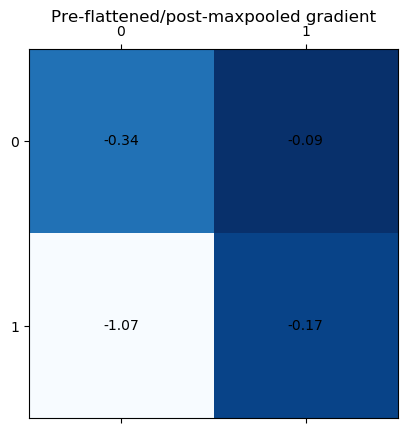

In [3575]:
delta = Matrix2D(delta_fcnn_weights.reshape(a2.data.shape))
delta.draw("Pre-flattened/post-maxpooled gradient")

#### Maxpool
Calculating the gradients through the maxpool operation is a bit more involved. It hinges on the fact that, since all non-max values for each window are discarded entirely, the max values are the only ones which we need to calculate the gradient for. That is why the maxpool function borrowed from the published example stores the indices of the max values, so we can insert the gradients from the decimated matrix (above) into a matrix with the same size as the original convolved input. The non-max indices will remain zero, but this is again not a problem since these gradients do not affect the loss.

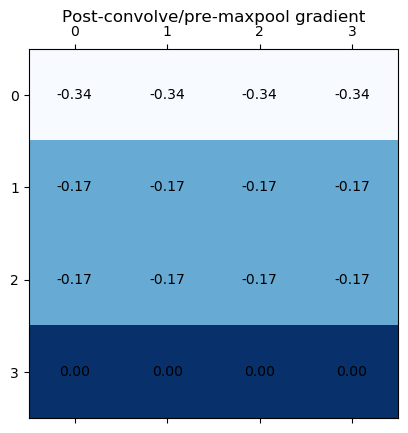

In [3576]:
delta_temp = np.zeros_like(a1.data)
for max_indices, gradient in zip(maxpool_indices, delta_fcnn_weights):
    delta_temp[max_indices] = gradient
delta = delta_temp
Matrix2D(delta).draw("Post-convolve/pre-maxpool gradient")

#### ReLU
The gradients propagate through the ReLU activation, which luckily is much simpler than the maxpool, since ReLU is either constant or linear. Mathematically, the gradient at this layer is simply (again using the chain rule)

$$
\frac{\partial L}{\partial z_1} = \frac{\partial L}{\partial a_1} \frac{\partial a_1}{\partial z_1} = \frac{\partial L}{\partial a_1} \cdot \text{ReLU}'(z_1)
$$

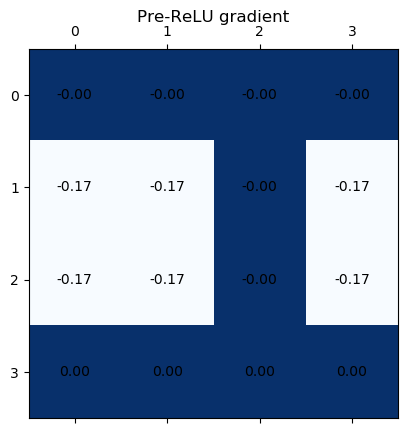

In [3577]:
# Derivative through the ReLU activation, which is simple (since relu is either const 0 or linear)
#Matrix2D(delta).draw()
delta = nn.relu(z1.data) * delta
Matrix2D(delta).draw("Pre-ReLU gradient")

#### Convolution

Calculating the derivative of the loss function w.r.t. the convolution kernel does not seem very easy at first, however, by utilizing the fact that convolution can be used to express derivatives, we may use the result

$$
\frac{\partial L}{\partial K} = X * \frac{\partial L}{\partial z_1}  
$$

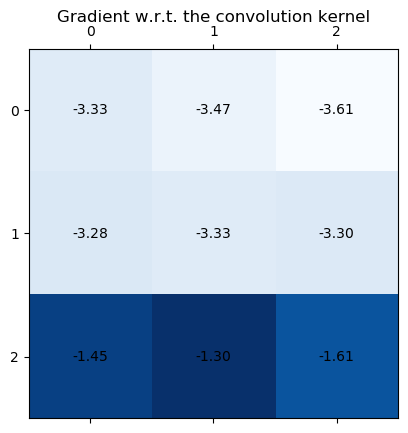

In [3578]:
# Derivative through the convolution operation
grad_b1 = delta.sum()
grad_kernel = X.convolve2D(Matrix2D(delta))
grad_kernel.draw("Gradient w.r.t. the convolution kernel")

#### Updating network parameters
As mentioned previously, the point of going through all these steps is to update the parameters of the network in such a manner as to decrease the numerical value of the loss function. We have now calculated gradients of the loss function w.r.t. the parameters in the network, and since the gradient is a vector pointing in the steepest (positive) direction at a given point on the manifold spanned by the network parameters, we may negate the gradient to find the *direction of steepest descent*, i.e. do a step of gradient descent. The learning rate, i.e. how far in the direction of steepest descent we perturb the network parameters, is a tunable hyperparameter. Too small, and the learning process takes an infeasibly long time, but too high and the process may overshoot minima and become unstable.

Here it is set arbitrary since "it just worked" :)

In [3579]:
# Update weights and biase for convolution
learning_rate = 0.01

nn.weights -= learning_rate * delta_fcnn_weights.T # Update weights for the FCNN
nn.fcnn_bias -= learning_rate * delta_fcnn_bias # Update bias for the FCNN

kernel.data -= learning_rate * grad_kernel.data
conv_bias -= learning_rate * grad_b1

In [3580]:
nn.backward = False
print(f"Network parameters: K = {kernel.data.flatten()}, b1 = {conv_bias}, w = {nn.weights[0]}, b2 = {nn.fcnn_bias}")

Network parameters: K = [ 0.13822081  0.21974461  0.94344559 -0.28346274 -0.54712018  0.36718822
 -0.07161526 -0.47661038 -0.04398431], b1 = 1.001663234302092, w = [-0.31981857  0.01498114  0.1213367   0.67142569], b2 = 0.933665993625171


# Experimentation and discussion

I initially thought that it could be interesting to see how softmax compares to sigmoid as the FCNN output activation function in this case. However, since softmax is a generalization of the sigmoid function for N classes, I realized that it would yield identical performance. Nonetheless, I went ahead and wrote a quick (read dirty) implementation, and tested it using the code found in the **Automatic training** section. As expected, this did not alter performance at all, and so I removed it during cleanup of the code.

A problem that I ran into at first, before choosing a symmetric distribution for class 0, was a problem with the convolved input matrix having all negative values, which then yields an all-zero matrix after the ReLU activation, which in turn degrades performance substantially. Additionally, training is almost certain to halt, since the gradient will also be zero. After reading up on the problem of "dead ReLUs" I found two alternatives:

1. "Leaky ReLU" with a slight positive gradient for negative values
2. "Exponential ReLU" where instead of a hard cutoff at zero, it decays exponentially after zero.

Leaky ReLU is implemented in the Network class, and proved to be effective in reducing ReLU death empirically when I was playing around with training. However, it comes at the cost of another hyperparameter, and as such I decided to simply lower the learning rate as a way to avoid ReLU deaths. Due to this, I did not implement the exponential ReLU.

# Automatic training
I am entirely neglecting the holy spirit of Validation here, but this is very much on purpose since this example is so deprived to begin with :)

In [3581]:
kernel = Matrix2D(np.random.uniform(low=-1, high=1, size=(3, 3)))
conv_bias = np.random.uniform()

fcnn_weights = np.random.uniform(low=-1, high=1, size=(1, 4))
fcnn_bias = np.random.uniform()

nn = Network(learning_rate=0.001, kernel=kernel, conv_bias=conv_bias, weights=fcnn_weights, fcnn_bias=fcnn_bias)

# Create Matrix2D for class 0 and 1
ndim = 6

# Train
n_training_samples = 1000
classes = np.concatenate((np.ones(n_training_samples // 2), np.zeros(n_training_samples // 2)))
np.random.shuffle(classes)

for y in classes: 

    if y == 0:
        X = Matrix2D.uniform_noise(ndim)
    else:
        X = Matrix2D.square(ndim, 3)

    nn.forward_pass(X, y)
    nn.backward_pass(X, y)


# Test
X = Matrix2D.uniform_noise(ndim)
print("Given a matrix without a square:")
nn.predict(X)

# Project a new sample and see how the network performs
X = Matrix2D.square(ndim, 3)
print("Given a matrix with a square:")
nn.predict(X)

/tmp/ipykernel_59655/2900413194.py:183: RuntimeWarning: divide by zero encountered in log10
  return  - (y * np.log10(p) + (1 - y) * np.log10(1 - p))
/tmp/ipykernel_59655/2900413194.py:183: RuntimeWarning: invalid value encountered in double_scalars
  return  - (y * np.log10(p) + (1 - y) * np.log10(1 - p))
/tmp/ipykernel_59655/2900413194.py:181: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - y) / (1 - p) - (y / p)
/tmp/ipykernel_59655/2900413194.py:150: RuntimeWarning: invalid value encountered in greater
  act = value > 0


Given a matrix without a square:
prob. for class 0 (no square): nan
prob. for class 1 (square): nan
Given a matrix with a square:
prob. for class 0 (no square): nan
prob. for class 1 (square): nan
